In [22]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from skimage.transform import resize
from keras.models import model_from_json
from keras import backend as K
K.clear_session()

In [23]:
dcm1=pydicom.dcmread('test1.dcm')
dcm1

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

In [41]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)  
    img = resize(ds.pixel_array,(224,224),anti_aliasing=True)
    study=ds.StudyDescription
    plt.imshow(img)
    
    if ds.PatientPosition not in['AP','PA']:
        print("Incorrect view position, it should be AP or PA, here it is ", ds.PatientPosition)
        return None, None
    elif ds.BodyPartExamined!='CHEST':
        print ("Incorrect body part examined in Diacom. it should be CHEST. it is instead :",ds.BodyPartExamined)
        return None, None
    elif ds.Modality!='DX':
        print ("Incorrect Modality in Diacom. it should be DX. it is instead :",ds.Modality)
        return None, None
    else:
        return img, study
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size):
#    img_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                   )
    my_image = np.repeat(img[..., np.newaxis], repeats = 3, axis = -1)
#    my_image=np.expand_dims(my_image, axis=0)
    my_image = my_image.reshape((img_size))
    proc_img = preprocess_input(my_image)

    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    # load json file and create model
    json_file=open(model_path,'r')
    model_json=json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    #load weights into new model
    model.load_weights(weight_path)
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    tmp_Y = model.predict(img,verbose=True)
    prediction=(tmp_Y>thresh)          
    return prediction 

Load file test1.dcm ...
1/1 [==============================] - 0s 114ms/step
Prediction : No Pneumonia
Actual: No Finding
Load file test2.dcm ...
1/1 [==============================] - 0s 35ms/step
Prediction : No Pneumonia
Actual: Cardiomegaly
Load file test3.dcm ...
1/1 [==============================] - 0s 36ms/step
Prediction : No Pneumonia
Actual: Effusion
Load file test4.dcm ...
Incorrect body part examined in Diacom. it should be CHEST. it is instead : RIBCAGE
Load file test5.dcm ...
Incorrect Modality in Diacom. it should be DX. it is instead : CT
Load file test6.dcm ...
Incorrect view position, it should be AP or PA, here it is  XX


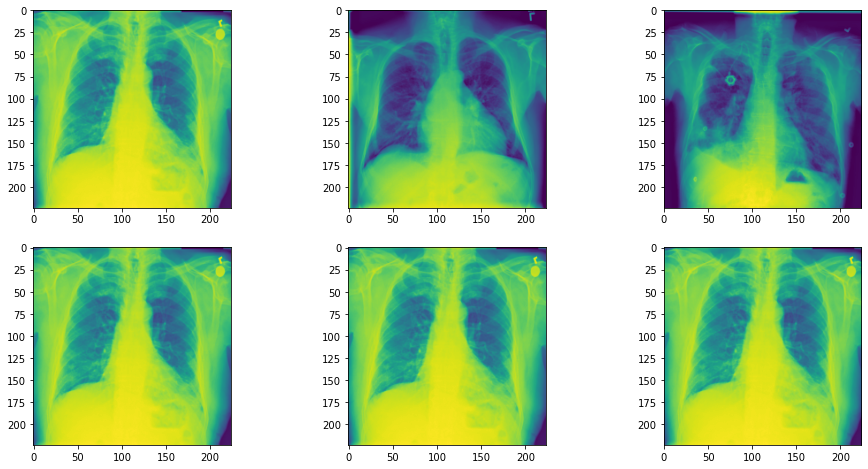

In [43]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json'#path to saved model
weight_path ='xray_class_my_model.best.hdf5' #path to saved best weights

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
img_mean =0.0 # loads the mean image value they used during training preprocessing
img_std =255.0 # loads the std dev image value they used during training preprocessing

my_model =load_model(model_path, weight_path) #loads model
thresh = 0.27 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
j=1
figure=plt.subplots(figsize=(16,8))
for i in test_dicoms:
    plt.subplot(2,3,j)
    img = np.array([])
    img,desc = check_dicom(i)
#    
#    plt.imshow(img)
    j +=1
      
    if img is None:        
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    if pred:
        pred_s='Pneumonia'
    else:
        pred_s='No Pneumonia'
            
    print("Prediction :",pred_s)
    print("Actual:",desc)